In [142]:
skip_training = True  # Set this flag to True before validation and submission

In [143]:
import tools, warnings
warnings.showwarning = tools.customwarn

In [144]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm

import tools
import tests

In [145]:
data_dir = tools.select_data_dir()

The data directory is /coursedata


In [146]:
# Select the device for training (use GPU if you have one)
#device = torch.device('cuda:0')
device = torch.device('cpu')

In [147]:
# The models are always evaluated on CPU
if skip_training:
    device = torch.device("cpu")

## Data

In [148]:
trainset = tools.MNIST(data_dir, train=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

Maximum pixel value: 1.3109885454177856
Minimum pixel value: -0.44087544083595276


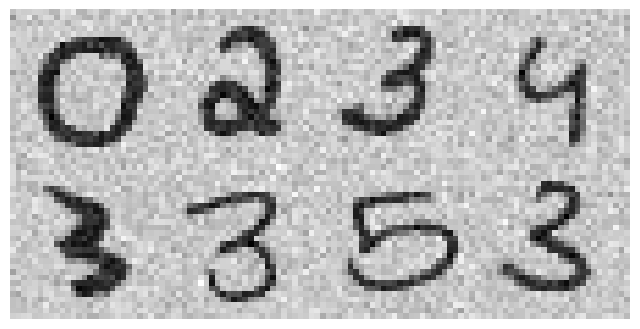

In [149]:
images, labels, idxs = next(iter(trainloader))
print("Maximum pixel value:", images.flatten().max().item())
print("Minimum pixel value:", images.flatten().min().item())
tools.show_images(images[:8], ncol=4, cmap='binary')

## Deep Latent Variable Models

### (Non-Amortized) Variational Inference

In this exercise, we will implement variational inference (VI) to learn the parameters of the following generative model:

$$
\boldsymbol{z} \sim p_\theta(\boldsymbol{z}) = \mathcal{N}(\boldsymbol{0}, I_L)
$$

$$
\boldsymbol{x} \mid \boldsymbol{z} \sim p_\theta(\boldsymbol{x} \mid \boldsymbol{z}) = \mathcal{N}(\boldsymbol{\mu}_\theta(\boldsymbol{z}), \boldsymbol{\sigma}_\theta^2I_D)
$$
where $\boldsymbol{z} \in \mathbb{R}^L$ is $L$ dimensional latent variable vector of a single sample $\boldsymbol{x} \in \mathbb{R}^D$ and $\boldsymbol{\mu}_\theta(\cdot)$ is a neural network, i.e. "decoder", with parameters $\theta$. For simplicity, we will assume $\boldsymbol{\sigma}_\theta \in \mathbb{R}^D$ is a vector of learnable scalars as a part of decoder parameters.


![VI Graphical Model](vi_graphical.png) 

We are interested in the posterior distribution of latent variables:

$$
p_\theta(\boldsymbol{z} \mid \boldsymbol{x}) = \frac{p_\theta(\boldsymbol{x} \mid \boldsymbol{z}) p_\theta(\boldsymbol{z})}{p_\theta(\boldsymbol{x})}
$$

which is intractable since the evidence term, $p_\theta(\boldsymbol{x})$, cannot be computed analitically. We will use VI to approximate $p_\theta(\boldsymbol{z} \mid \boldsymbol{x})$ by a variational distribution $q_\psi(z)$ with variational parameters denoted by $\psi$. Then our objective becomes minimizing the reverse Kullback-Leibler (KL) divergence $\text{KL}(q_\psi(\boldsymbol{z}) \mid \mid p_\theta(\boldsymbol{z} \mid \boldsymbol{x}))$, which is equivalent to maximizing evidence lower bound (ELBO):

$$
\log p_\theta(\boldsymbol{x}) \geq \underbrace{\mathbb{E}_{q_\psi(\boldsymbol{z})}\left[\log p_\theta(\boldsymbol{x} \mid \boldsymbol{z}) \right]}_{\text{expected log likelihood}} - \underbrace{\text{KL}\left(q_\psi(\boldsymbol{z}) \mid \mid p_\theta(\boldsymbol{z})\right)}_{\text{KL of the posterior from prior}}
$$

where the first term measures the reconstruction loss and the second term can be interpreted as prior regularization.


In this task, we assume the following variational distribution per observation:

$$q_{\psi_n}(\boldsymbol{z_n}) = \mathcal{N}(\boldsymbol{\mu}_n, \boldsymbol{\sigma}_n^2 I_L)$$


For $N$ observations the joint distribution factorizes across samples:

\begin{align*}
p_\theta(\boldsymbol{x}_{1:N}, \boldsymbol{z}_{1:N}) &= p_\theta(\boldsymbol{x}_{1:N} \mid \boldsymbol{z}_{1:N}) p_\theta(\boldsymbol{z}_{1:N}) \\
&= \prod_{n = 1}^N p_\theta(\boldsymbol{x}_{n} \mid \boldsymbol{z}_{n}) p_\theta(\boldsymbol{z}_{n})
\end{align*}

Moreover, we assume mean-field approximation as the variational family:

$$
q(\boldsymbol{z}_{1:N}) = \prod_{n = 1}^N q_{\psi_n}(\boldsymbol{z}_n)
$$

Hence, we have ELBO that also factorizes as follows:

$$\log p_\theta(\boldsymbol{x}_{1:N}) \geq \text{ELBO}(\theta, \psi_{1:N} \mid \boldsymbol{x}_{1:N}) = \sum_{n = 1}^N \text{ELBO}(\theta, \psi_{n} \mid \boldsymbol{x}_{n})$$

In the coding part, you will minimize the negative of ELBO (- ELBO) which is equivalent to maximizing ELBO.

$$
- \text{ELBO}(\theta, \psi_{n} \mid \boldsymbol{x}_{n}) = - \mathbb{E}_{q_\psi(\boldsymbol{z}_n)}\left[\log p_\theta(\boldsymbol{x}_n \mid \boldsymbol{z}_n) \right] + \text{KL}\left(q_\psi(\boldsymbol{z}_n) \mid \mid p_\theta(\boldsymbol{z}_n)\right)
$$

- Negative log-likelihood: $- \log p_\theta(\boldsymbol{x} \mid \boldsymbol{z})$
- Regularization: $\text{KL}\left(q_\psi(\boldsymbol{z}) \mid \mid p_\theta(\boldsymbol{z})\right)$

where we drop the sample index $n$ for simplicity.

You will derive negative log-likelihood in the following task. Derivation for KL of two Gaussians is provided in the lecture slides.


#### Derivation: Negative log-likelihood (1 point)

Derive $- \log p_\theta(\boldsymbol{x} \mid \boldsymbol{z})$ here. Hints:

- Make use of diagonal covariance to ease your work.
- Omit the constant term $\frac{D}{2} \log(2 \pi)$.


YOUR ANSWER HERE



Since the covariance matrix is diagonal, the dimensions of $ \mathbf{x} $ are independent given $ \mathbf{z} $, allowing us to express the probability density as a product of univariate normal distributions:

$$
p_\theta(\mathbf{x} \mid \mathbf{z}) = \prod_{d=1}^D \mathcal{N}(x_d \mid \mu_{\theta,d}(\mathbf{z}), \sigma_{\theta,d}^2)
$$

where each term is:

$$
\mathcal{N}(x_d \mid \mu_{\theta,d}(\mathbf{z}), \sigma_{\theta,d}^2) = \frac{1}{\sqrt{2\pi} \sigma_{\theta,d}} \exp\left( -\frac{(x_d - \mu_{\theta,d}(\mathbf{z}))^2}{2 \sigma_{\theta,d}^2} \right)
$$

Taking the logarithm, the log-likelihood becomes:

$$
\log p_\theta(\mathbf{x} \mid \mathbf{z}) = \sum_{d=1}^D \log \mathcal{N}(x_d \mid \mu_{\theta,d}(\mathbf{z}), \sigma_{\theta,d}^2)
$$

Substituting the expression for the normal density:

$$
\log p_\theta(\mathbf{x} \mid \mathbf{z}) = \sum_{d=1}^D \left[ -\frac{1}{2} \log(2\pi) - \frac{1}{2} \log(\sigma_{\theta,d}^2) - \frac{(x_d - \mu_{\theta,d}(\mathbf{z}))^2}{2 \sigma_{\theta,d}^2} \right]
$$

This simplifies to:

$$
\log p_\theta(\mathbf{x} \mid \mathbf{z}) = -\frac{D}{2} \log(2\pi) - \sum_{d=1}^D \frac{1}{2} \log(\sigma_{\theta,d}^2) - \frac{1}{2} \sum_{d=1}^D \frac{(x_d - \mu_{\theta,d}(\mathbf{z}))^2}{\sigma_{\theta,d}^2}
$$

Thus, the negative log-likelihood is:

$$
-\log p_\theta(\mathbf{x} \mid \mathbf{z}) = \frac{D}{2} \log(2\pi) + \sum_{d=1}^D \frac{1}{2} \log(\sigma_{\theta,d}^2) + \frac{1}{2} \sum_{d=1}^D \frac{(x_d - \mu_{\theta,d}(\mathbf{z}))^2}{\sigma_{\theta,d}^2}
$$

Omitting the constant term, we obtain:

$$
-\log p_\theta(\mathbf{x} \mid \mathbf{z}) = \sum_{d=1}^D \frac{1}{2} \log(\sigma_{\theta,d}^2) + \frac{1}{2} \sum_{d=1}^D \frac{(x_d - \mu_{\theta,d}(\mathbf{z}))^2}{\sigma_{\theta,d}^2}
$$

$\textbf{Ans.}$
$$
-\log p_\theta(\mathbf{x} \mid \mathbf{z}) = \sum_{d=1}^D \left[ \frac{1}{2} \log(\sigma_{\theta,d}^2) + \frac{(x_d - \mu_{\theta,d}(\mathbf{z}))^2}{2 \sigma_{\theta,d}^2} \right]
$$



#### Coding: Decoder

$$p_\theta(\boldsymbol{x} \mid \boldsymbol{z}) = \mathcal{N}(\boldsymbol{\mu}_\theta(\boldsymbol{z}), \boldsymbol{\sigma}_\theta^2I_D)$$
We will use the following architecture for our decoder (generative network):
* Fully-connected layer with 250 output features, followed by ReLU
* Fully-connected layer with 250 input features, followed by ReLU
* `ConvTranspose2d` layer with kernel size 5 with 16 input channels, followed by ReLU
* `ConvTranspose2d` layer with kernel size 5 with 6 input channels.

**Important note about learning $\boldsymbol{\sigma}^2_\theta$:**

In many probabilistic models, we need to ensure that variances remain strictly positive. Moreover, directly predicting variance can cause numerical issues if the model tries to produce values near zero or negative. To ensure positivity and stability, we will parameterize the variance of predictions in log space and restrict it to have a minimum value as follows:
```
self.register_buffer('min_logvar', -6 * torch.ones(1))
```

We need to use `register_buffer` to ensure that the variable is on the same device as the trained parameters of the model. 

* You need to initialize a `trainable` set of parameters as `self._logvar` to tensor consting of **0s** in the `__init__` method of your decoder class.
* You will implement a method `get_logvar` to get the logvar parameters using the following code:

```
logvar = self.min_logvar + F.softplus(self._logvar - self.min_logvar)
```

In [150]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        """
        Args:
          latent_dim (int): Dimensionality of the latent space.
        """
        super(Decoder, self).__init__()
        self._logvar = None

        # YOUR CODE HERE
        self.register_buffer('min_logvar', -6*torch.ones(1))
        self._logvar = nn.Parameter(torch.zeros((1,28,28)))
        self.act = nn.ReLU()
        self.fc1 = nn.Linear(latent_dim, 250)
        self.fc2 = nn.Linear(250, 20*20*16)
        self.cn1 = nn.ConvTranspose2d(in_channels=16, out_channels=6, kernel_size=5)
        self.cn2 = nn.ConvTranspose2d(in_channels=6, out_channels=1, kernel_size=5)
        #raise NotImplementedError()
        
    def get_logvar(self):
        # YOUR CODE HERE
        logvar = self.min_logvar + F.softplus(self._logvar - self.min_logvar)
        return logvar
        #raise NotImplementedError()
    
    def forward(self, z):
        """
        Args:
          z of shape (batch_size, latent_dim): Tensor of latent variables.

        Returns:
          x_hat of shape (batch_size, n_channels=1, width, height): Tensor of reconstructed images.
        """
        # YOUR CODE HERE
        #var = get_logvar()
        mean = self.act(self.fc1(z))
        mean = self.act(self.fc2(mean))
        mean = mean.reshape(z.shape[0], 16, 20, 20)
        mean = self.act(self.cn1(mean))
        mean = self.cn2(mean)
        
        return mean
        #raise NotImplementedError()

In [151]:
def test_Decoder_shapes():
    latent_dim = 10
    decoder = Decoder(latent_dim=latent_dim)

    z = torch.randn(3, latent_dim)
    x_hat = decoder(z)
    x_hat_shape = torch.Size([3, 1, 28, 28])
    
    logvar = decoder.get_logvar()
    logvar_shape = torch.Size([1, 28, 28])
    _logvar_val = np.zeros(28 * 28)
    assert x_hat.shape == x_hat_shape, "Bad shape of x_hat: x_hat.shape={}".format(x_hat.shape)
    assert logvar.shape == logvar_shape, "Bad shape of logvar: logvar.shape={}".format(logvar.shape)
    assert decoder._logvar.requires_grad, "Logvar must be trainable"
    assert all(decoder._logvar.detach().flatten().numpy() == _logvar_val), "Logvar must be initialized to 0"
    print('Success')
    
test_Decoder_shapes()

Success


#### Coding: Negative log-likelihood loss (1 point)

Implement the expected NLL that you derived previously.

**Notes:** 

* Your implementation **should not** include constant term $\frac{28 * 28}{D} \log 2\pi$.
* Make use of **diagonal covariance** structure to simplify computations.


In [152]:
def nll_loss(x, x_hat, logvar):
    """
     Args:
        x of shape (batch_size, 1, 28, 28): Training samples.
        x_hat of shape (batch_size, 1, 28, 28): Predictive mean of the generated sample.
        logvar of shape (1, 28, 28): Log-variance of the generated pixels.
    
    Returns:
        nll (torch scalar): Negative log-likelihood loss, averaged over the batch.
    """
    # YOUR CODE HERE
    nll = 0.5*logvar + (0.5*(x - x_hat)**2)*torch.exp(-logvar)
    nll = torch.sum(nll, dim=[1,2,3])
    nll = torch.mean(nll)
    return nll
    raise NotImplementedError()

In [153]:
def test_nll_loss():
    x_hat = torch.ones(3, 1, 28, 28) 
    logvar = torch.log(2*torch.ones(1, 28, 28))
    logvar[:,:14,:] = torch.log(torch.ones(1, 14, 28))

    x = torch.zeros(3, 1, 28, 28)
    x[:,:,:14,:] = torch.ones(1, 14, 28)

    nll = nll_loss(x, x_hat, logvar)
    expected = torch.tensor(233.8568572998047)
    
    print('loss:', nll)
    print('expected:', expected)
    assert torch.allclose(nll, expected), "nll does not match expected value."
    print('Success')

test_nll_loss()

loss: tensor(233.8568)
expected: tensor(233.8569)
Success


#### Coding: Kullback-Leibler Divergence (1 point)

Implement KL divergence:

$$
\frac{1}{B} \sum_{n = 1}^B \text{KL}\left(q_\psi(\boldsymbol{z}_n) \mid \mid p_\theta(\boldsymbol{z}_n)\right)
$$

where $B$ is the batch size and

\begin{align*}
q_{\psi_n}(\boldsymbol{z_n}) &= \mathcal{N}(\boldsymbol{\mu}_n, \boldsymbol{\sigma}_n^2 I_L)\\
p_\theta(\boldsymbol{z}_n) &= \mathcal{N}(\boldsymbol{0}, I_L)
\end{align*}

**Notes:**
* Please do **not** use functions from the `torch.distributions` module. 
* Make use of **diagonal covariance** structure to simplify computations.

In [154]:
def kl_loss(z_mu, z_logvar):
    """
    Args:
      z_mu of shape (batch_size, latent_dim): Means of the approximate distributions of the latent variables.
      z_logvar of shape (batch_size, latent_dim): Log-variance of the approximate distributions of the latent variables.
    
    Returns:
      loss (torch scalar): Kullback-Leibler divergence, averaged over the batch.
    """
    # YOUR CODE HERE
    kl = 0.5*(torch.exp(z_logvar) + (z_mu**2) - 1 - z_logvar)
    kl = torch.sum(kl, dim=1)
    loss = torch.mean(kl)
    return loss
    #raise NotImplementedError()
    

In [155]:
def test_loss_kl():
    latent_dim = 3
    z_mu = torch.zeros(3, latent_dim)
    z_logvar = torch.log(2*torch.ones(3, latent_dim))
    kl = kl_loss(z_mu, z_logvar)
    expected = torch.tensor(0.4602792263031006)
    print('kl:', kl.item())
    print('expected:', expected.item())
    assert torch.allclose(kl, expected, atol=1e-5), "loss does not match expected value."
    print('Success')

test_loss_kl()

kl: 0.4602792263031006
expected: 0.4602792263031006
Success


#### Coding: Variational distribution

In the following cell, you need to initialize variational distribution per observation.

\begin{align*}
q(\boldsymbol{z}_{1:N}) &= \prod_{n = 1}^N q_{\psi_n}(\boldsymbol{z}_n)\\
q_{\psi_n}(\boldsymbol{z}_n) &= \mathcal{N}(\boldsymbol{\mu}_n, \boldsymbol{\sigma}_n^2 I_L)
\end{align*}

**Important note about learning $\boldsymbol{\sigma}^2_n$:**

As mentioned previously, we need to ensure positivity on variances. Again, we will achieve this by parameterizing variance in the log space, $\log \boldsymbol{\sigma}^2_n$. Hence, variational parameters become $\psi_n = \{\boldsymbol{\mu}_n, \log \boldsymbol{\sigma}^2_n\}$. We can obtain the positive variance by just exponentiating log-variances, $\boldsymbol{\sigma}^2_n = \exp(\log \boldsymbol{\sigma}^2_n)$. 

* **Do not set a minimum value** for the variance in this case.

* Use 0 as the initial value for $\boldsymbol{\mu}$.
* Use 1 as the initial value for $\log \boldsymbol{\sigma}^2$.

In [156]:
def init_variational_parameters(N, latent_dim):
    """
    Args:
        N (int): Number of training samples.
        latent_dim (int): Dimensionality of the latent space.
    Returns:
        mu_psi of shape (N, latent_dim): Means of the approximate distributions of the latent variables.
        logvar_psi of shape (N, latent_dim): Log-variance of the approximate distributions of the latent variables.
    """
    # YOUR CODE HERE
    mu = nn.Parameter(torch.zeros(N,latent_dim))
    logvar = nn.Parameter(torch.ones(N,latent_dim))
    
    return mu, logvar
    #raise NotImplementedError()

In [157]:
def test_variational_parameters():
    mu_psi, logvar_psi = init_variational_parameters(100, 3)
    param_shape = torch.Size([100, 3])
    assert mu_psi.shape == param_shape, "Bad shape of mu_psi: mu_psi.shape={}".format(mu_psi.shape)
    assert logvar_psi.shape == param_shape, "Bad shape of logvar_psi: logvar_psi.shape={}".format(logvar_psi.shape)
    assert mu_psi.requires_grad, "mu_psi must be trainable"
    assert logvar_psi.requires_grad, "logvar_psi must be trainable"
    print('Success')

test_variational_parameters()

Success


#### Coding: Reparameterization trick for sampling

We have the variational distribution with parameters $$\psi = \{\boldsymbol{\mu}, \log \boldsymbol{\sigma}^2\}$$ and we need to sample latent variables from the distribution. We will do this as follows:


\begin{align*}
\boldsymbol{\epsilon} &\sim \mathcal{N}(\boldsymbol{0}, I_L)\\
\boldsymbol{\sigma} &= \sqrt{\exp (\log \boldsymbol{\sigma}^2)}\\
\boldsymbol{z} &= \boldsymbol{\mu} + \text{diag}(\boldsymbol{\sigma}) \boldsymbol{\epsilon}
\end{align*}


In [158]:
def sample_latent(z_mu, z_logvar):
    """
    Args:
        z_mu of shape (batch_size, latent_dim): Means of the approximate distributions of the latent variables.
        z_logvar of shape (batch_size, latent_dim): Log-variance of the approximate distributions of the latent variables.
    
    Returns:
        z of shape (batch_size, latent_dim): Sampled latent variables.
    """
    # YOUR CODE HERE
    sigma = torch.sqrt(torch.exp(z_logvar))
    epsilon = torch.normal(0, torch.eye(z_mu.shape[1]))
    #epsilon = torch.randn_like(z_mu)
    z = z_mu + sigma@epsilon
    return z
    #raise NotImplementedError()

In [159]:
def test_sample():
    latent_dim = 10
    z_mu = torch.zeros(3, latent_dim)
    z_logvar = torch.log(2*torch.ones(3, latent_dim))
    z = sample_latent(z_mu, z_logvar)
    assert z.shape == z_mu.shape, f"Bad z.shape: {z.shape}"
    print('Success')

test_sample()

Success


#### Coding: Packed VI model (1 point)

We will put all components together to reduce repetitive code. Implement the `loss` and `forward` functions of the VI class in the cell below. 

* `loss` function should return - ELBO averaged for the given samples.
* `forward` function (i) fetches the local variational parameters of the training samples, (ii) samples latent variables and (iii) decodes them to predict images.

In [205]:
class VI(nn.Module):
    def __init__(self, N, latent_dim):
        """
        Args:
          N (int): Number of observations in the dataset.
          latent_dim (int): Dimensionality of the latent space.
        """
        super(VI, self).__init__()
        self.latent_dim = latent_dim
        self.decoder = Decoder(latent_dim)
        self.mu_psi, self.logvar_psi = init_variational_parameters(N, latent_dim)

    def loss(self, x, x_hat, index):
        """
        Args:
          x of shape (batch_size, n_channels=1, width=28, height=28): Training samples.
          x_hat of shape (batch_size, n_channels=1, width=28, height=28): Predictive mean of the images.
          index of shape (batch_size): Index of the training samples.

        Returns:
          loss (torch scalar): Loss (- ELBO) averaged over the batch.
        """
        # YOUR CODE HERE
        logvar = self.decoder.get_logvar()
        nll = nll_loss(x, x_hat, logvar)
        #kl = kl_loss(x_hat, logvar)
        kl = kl_loss(self.mu_psi[index], self.logvar_psi[index])
        loss = nll + kl
        return loss
        #raise NotImplementedError()
    
    def forward(self, index):
        """
        Args:
          index of shape (batch_size): Index of the training samples.

        Returns:
          x_hat of shape (batch_size, n_channels=1, width=28, height=28): Predictive mean of the images.
        """
        # YOUR CODE HERE
        z = sample_latent(self.mu_psi[index], self.logvar_psi[index])
        x_hat = self.decoder(z)
        return x_hat
        
        #raise NotImplementedError()

In [199]:
def test_VI_ELBO():
    N = 3
    latent_dim = 10
    tes_vi = VI(N, latent_dim)

    x_hat = torch.ones(3, 1, 28, 28)

    x = torch.zeros(3, 1, 28, 28)
    x[:,:,:14,:] = torch.ones(1, 14, 28)
    
    index = torch.tensor([0, 1, 2])
    loss = tes_vi.loss(x, x_hat, index)

    expected = torch.tensor(200.07723999023438)
    
    print('-ELBO:', loss)
    print('expected:', expected)
    assert torch.allclose(loss, expected), "loss does not match expected value."
    print('Success')
test_VI_ELBO()

-ELBO: tensor(200.0773, grad_fn=<AddBackward0>)
expected: tensor(200.0772)
Success


#### Training setup for VI model

We will use a small subset of the MNIST dataset for the VI model training since optimizing local parameters individually for the entire dataset is a challenging task. We will make use of 1000 random samples from the dataset.

In [171]:
torch.manual_seed(0)
np.random.seed(0)
N = 1000
vi_trainset = tools.MNIST(data_dir, train=True, N=N)
vi_trainloader = torch.utils.data.DataLoader(vi_trainset, batch_size=32, shuffle=True)
L = 10
vi_model = VI(N, L)
vi_model = vi_model.to(device)

#### Coding: Training loop (2 points)

The `vi_trainloader` provides images, labels, and indexes of the samples in the batch. 

Implement the training loop in the cell below. The recommended hyperparameters:
* Adam optimizer with a learning rate of 0.001
* Number of epochs: 1000

Hints:
- The loss after 1000 epochs should be less than -1050.

In [172]:
# Training loop
if not skip_training:
    # YOUR CODE HERE
    optimizer = torch.optim.Adam(vi_model.parameters(), lr = 0.001)
    epochs = 1000
    
    for epoch in range(epochs):
        
        epoch_loss = 0
        for images, labels, index in vi_trainloader:
            optimizer.zero_grad()
            images = images.to(device)
            out = vi_model(index)
            loss = vi_model.loss(images, out, index)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
        if (epoch+1) % 100 == 0:
            print(f'Epoch {epoch+1}')
            print(f'Training loss: {epoch_loss/len(vi_trainloader)}')
    #raise NotImplementedError()

Epoch 100
Training loss: -743.6464691162109
Epoch 200
Training loss: -892.8644409179688
Epoch 300
Training loss: -912.548318862915
Epoch 400
Training loss: -931.6056499481201
Epoch 500
Training loss: -952.6633129119873
Epoch 600
Training loss: -984.8449077606201
Epoch 700
Training loss: -1007.3161697387695
Epoch 800
Training loss: -1028.9720478057861
Epoch 900
Training loss: -1054.4511947631836
Epoch 1000
Training loss: -1085.7250366210938


In [173]:
if not skip_training:
    tools.save_model(vi_model, '2_vi_model.pth', confirm=True)

Do you want to save the model (type yes to confirm)?  yes


Model saved to 2_vi_model.pth.


In [174]:
if skip_training:
    vi_model = VI(N, L)
    tools.load_model(vi_model, '2_vi_model.pth', device)

Use t-SNE


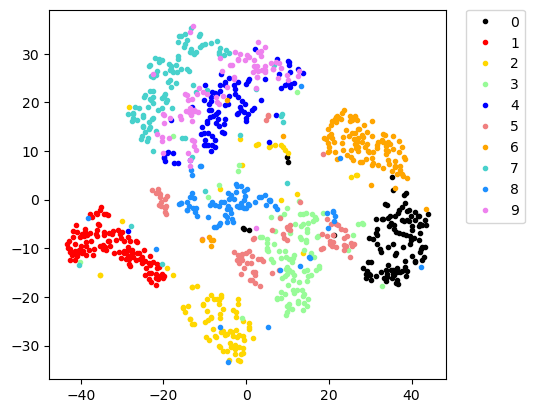

In [175]:
tests.visualize_embeddings(vi_model.mu_psi, vi_trainloader, n_samples=1000, device=device, avi = False)

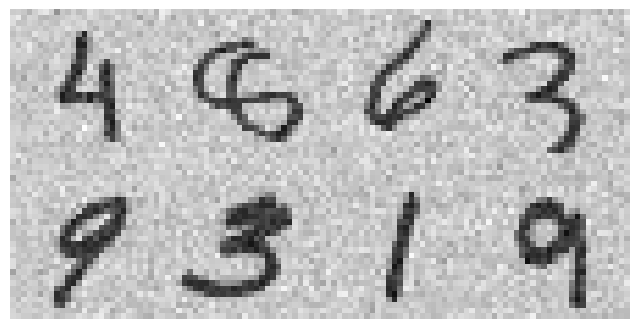

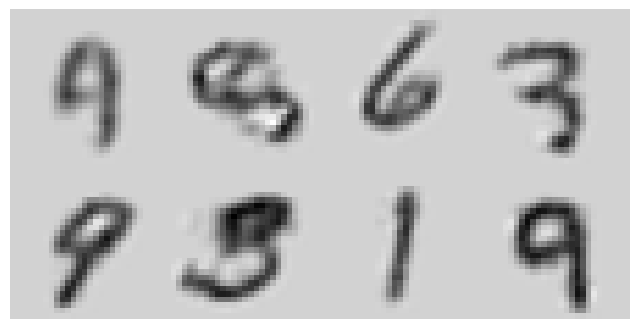

In [176]:
with torch.no_grad():
    dataiter = iter(vi_trainloader)
    images, _, index = next(dataiter)
    images = images.to(device)
    x_hat = vi_model(index)
    tools.show_images(images.cpu()[:8], ncol=4, cmap='binary')
    tools.show_images(x_hat.cpu()[:8], ncol=4, cmap='binary')

In [178]:
# This cell tests your model. Do not remove.

### Amortized Variational Inference

In standard VI we have local variational parameters per data point, which allows us to be flexible and even find the global parameters of the used variational family (mean-field). However, we face the following problems:

1. We might have a large number of observations, $N$, which means we would have a large number of free parameters that need to be optimized separately. To achieve optimal parameters we should perform many training epochs which can take quite a lot of time.
2. Optimized parameters are restricted to observations. When there is a separate test set, which is not observed during the training, we have no information about the posterior distribution. Hence, VI cannot generalize to unseen data points.

Instead of learning the local variational parameters of each sample separately, we can learn a **global** function to predict local variational parameters:

$$\psi_n = f_{\phi}(\boldsymbol{x}_n)$$

where $f_\phi(\cdot)$ called the recognition network or simply encoder that provides:

1. Faster convergence since each update improves inference for **all** data via a shared encoder.
2. Generalization to the unseen data. We can learn the approximate posterior of unseen data points by providing the data to the encoder network.
3. Fixed number of trainable parameters that are independent of the dataset size.

![AVI Graphical Model](avi_graphical.png) 

#### Coding: Encoder
$$\psi_n = \{\boldsymbol{\mu}_n, \log \boldsymbol{\sigma}^2_n\} = f_{\phi}(\boldsymbol{x}_n)$$
We will use the following architecture for our encoder (recognition network):
* `Conv2d` layer with kernel size 5 with 6 output channels, followed by ReLU
* `Conv2d` layer with kernel size 5 with 16 output channels, followed by ReLU
* Fully-connected layer with 250 output features, followed by ReLU
* Two heads: each is a fully-connected layer with `latent_dim` elements.

The two heads are needed to produce two outputs of the encoder:
* means $\boldsymbol{\mu}_n$ of the approximate distribution of the latent varibles.
* log-variances $\log \boldsymbol{\sigma}_n^2$ of the approximate distribution of the latent variables.

To guarantee that the variance is positive, we parameterize it as $\boldsymbol{\sigma}_n^2 = \exp(\log \boldsymbol{\sigma}_n^2)$.

In [243]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        """
        Args:
          latent_dim (int): Dimensionality of the latent space
        """
        super(Encoder, self).__init__()
        # YOUR CODE HERE
        self.act = nn.ReLU()
        self.cn1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.cn2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=20*20*16, out_features=250)
        self.head1 = nn.Linear(in_features=250, out_features=latent_dim)
        self.head2 = nn.Linear(in_features=250, out_features=latent_dim)
        #raise NotImplementedError()
        
    def forward(self, x):
        """
        Args:
          x of shape (batch_size, n_channels=1, width, height): Examples to encode.

        Returns:
          z_mu of shape (batch_size, latent_dim): Means of the approximate distributions of the codes.
          z_logvar of shape (batch_size, latent_dim): Log-variances of the approximate distributions of the codes.
        """
        # YOUR CODE HERE
        x = self.act(self.cn1(x))
        x = self.act(self.cn2(x))
        x = x.reshape(x.shape[0], -1)
        x = self.act(self.fc1(x))
        z_mu = self.head1(x)
        z_logvar = self.head2(x)
        
        return z_mu, z_logvar
        #raise NotImplementedError()

#### Coding: Packed AVI model (1 point)

We will put all components together to reduce repetitive code. Implement the `loss` and `forward` functions of the AVI class in the cell below. 

* `loss` function should return - ELBO averaged for the given samples.
* `forward` function (i) encodes the given training samples and obtains variational parameters, (ii) samples latent variables and (iii) decodes them to predict images.

In [244]:
class AVI(nn.Module):
    def __init__(self, latent_dim):
        """
        Args:
          latent_dim (int): Dimensionality of the latent space.
        """
        super(AVI, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)
    
    def loss(self, x, x_hat, z_mu, z_logvar):
        """
        Args:
          x of shape (batch_size, n_channels=1, width=28, height=28): Training samples.
          x_hat of shape (batch_size, n_channels=1, width=28, height=28): Predictive mean of the images.
          z_mu of shape (batch_size, latent_dim): Means of the approximate distributions of the latent variables.
          z_logvar of shape (batch_size, latent_dim): Log-variance of the approximate distributions of the latent variables.

        Returns:
          loss (torch scalar): Loss (- ELBO) averaged over the batch.
        """
        # YOUR CODE HERE
        logvar = self.decoder.get_logvar()
        nll = nll_loss(x, x_hat, logvar)
        kll = kl_loss(z_mu, z_logvar)
        loss = nll + kll
        return loss
        raise NotImplementedError()
    
    def forward(self, x):
        """
        Args:
          x of shape (batch_size, n_channels=1, width=28, height=28): Training samples.

        Returns:
          x_hat of shape (batch_size, n_channels=1, width=28, height=28): Predictive distribution of the images.
          z_mu of shape (batch_size, latent_dim): Means of the approximate distributions of the latent variables.
          z_logvar of shape (batch_size, latent_dim): Log-variance of the approximate distributions of the latent variables.
        """
        # YOUR CODE HERE
        z_mu, z_logvar = self.encoder(x)
        z = sample_latent(z_mu, z_logvar)
        x_hat = self.decoder(z)
        return x_hat, z_mu, z_logvar
        #raise NotImplementedError()

In [245]:
def test_AVI_ELBO():
    latent_dim = 10
    tes_avi = AVI(latent_dim)

    x_hat = torch.ones(3, 1, 28, 28)
    x = torch.zeros(3, 1, 28, 28)
    x[:,:,:14,:] = torch.ones(1, 14, 28)

    z_mu = torch.zeros(3, latent_dim)
    z_logvar = torch.log(2*torch.ones(3, latent_dim))
    
    loss = tes_avi.loss(x, x_hat, z_mu, z_logvar)
    expected = torch.tensor(198.0200958251953)
    
    print('-ELBO:', loss)
    print('expected:', expected)
    assert torch.allclose(loss, expected), "loss does not match expected value."
    print('Success')
test_AVI_ELBO()

-ELBO: tensor(198.0201, grad_fn=<AddBackward0>)
expected: tensor(198.0201)
Success


In [246]:
torch.manual_seed(0)
np.random.seed(0)
L = 10
avi_model = AVI(L)
avi_model = avi_model.to(device)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

#### Coding: Training loop

The `trainloader` provides images, labels, and indexes of the samples in the batch. You can ignore indexes in AVI training.

Implement the training loop in the cell below. The recommended hyperparameters:
* Adam optimizer with a learning rate of 0.001
* Number of epochs: 10

Hints:
- The loss after 10 epochs should be less than -1140.

In [247]:
if not skip_training:
    # YOUR CODE HERE
    optimizer = torch.optim.Adam(avi_model.parameters(), lr = 0.001)
    epochs = 10
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}")
        epoch_loss = 0
        for images, labels, indexes in trainloader:
            optimizer.zero_grad()
            pred, z_mu,z_logvar = avi_model(images)
            loss = avi_model.loss(images, pred, z_mu, z_logvar)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
        print(f"Training loss: {epoch_loss/len(trainloader)}")
    #raise NotImplementedError()

Epoch 1
Training loss: -294.60757074313165
Epoch 2
Training loss: -829.1174671549479
Epoch 3
Training loss: -1063.860430045573
Epoch 4
Training loss: -1107.4943517578124
Epoch 5
Training loss: -1116.0761667317709
Epoch 6
Training loss: -1122.2109041666668
Epoch 7
Training loss: -1126.5179912109375
Epoch 8
Training loss: -1130.2400103515624
Epoch 9
Training loss: -1133.512504622396
Epoch 10
Training loss: -1136.1666428385417


In [248]:
if not skip_training:
    tools.save_model(avi_model, '2_avi_model.pth', confirm=True)

Do you want to save the model (type yes to confirm)?  yes


Model saved to 2_avi_model.pth.


In [249]:
if skip_training:
    avi_model = AVI(L)
    tools.load_model(avi_model, '2_avi_model.pth', device)

Use t-SNE


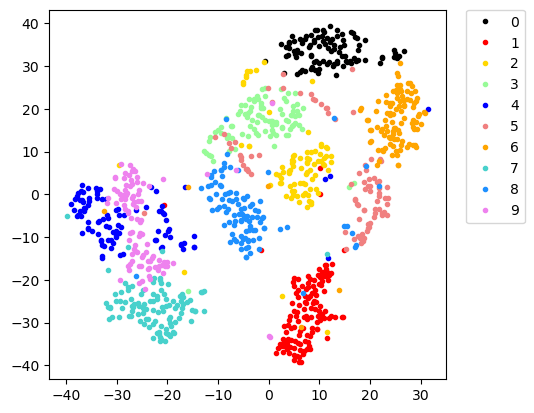

In [250]:
tests.visualize_embeddings(lambda x: avi_model.encode(x)[0], trainloader, n_samples=1000, device=device, avi = True)

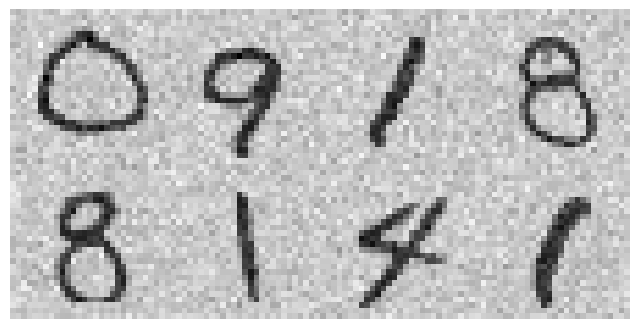

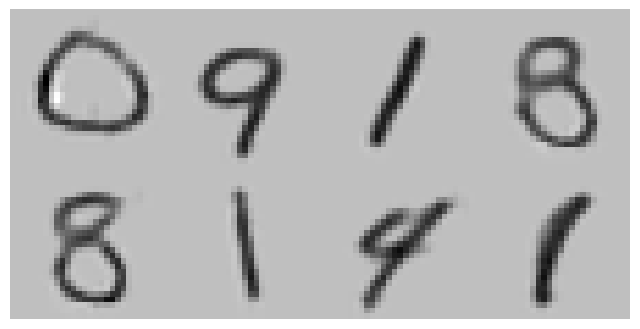

In [251]:
with torch.no_grad():
    dataiter = iter(trainloader)
    images, _, _ = next(dataiter)
    images = images.to(device)
    x_hat, _, _ = avi_model(images)
    tools.show_images(images.cpu()[:8], ncol=4, cmap='binary')
    tools.show_images(x_hat.cpu()[:8], ncol=4, cmap='binary')

#### Test the quality of the produced embeddings of unobserved data (2 points)

In [252]:
testset = tools.MNIST(data_dir, train=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

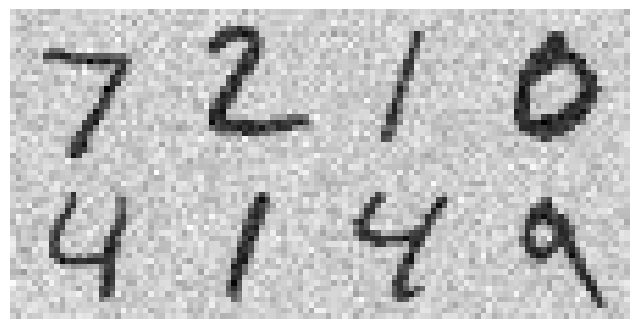

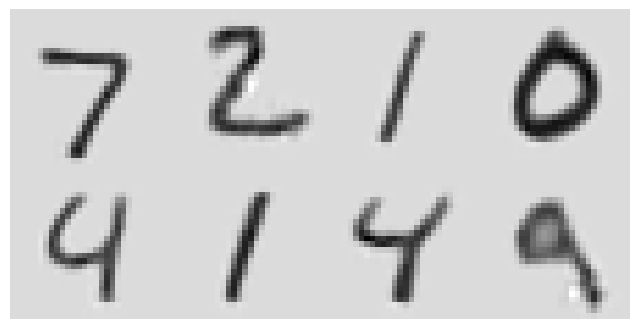

In [253]:
with torch.no_grad():
    dataiter = iter(testloader)
    images, _, _ = next(dataiter)
    images = images.to(device)
    x_hat, _, _ = avi_model(images)
    tools.show_images(images.cpu()[:8], ncol=4, cmap='binary')
    tools.show_images(x_hat.cpu()[:8], ncol=4, cmap='binary')

In [254]:
# Encode data samples using the AVI encoder
@torch.no_grad()
def encode(dataset, encoder):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=False)
    embeddings = []
    labels = []
    for images, labels_, _ in dataloader:
        mu, logsigma = encoder(images.to(device))
        embeddings.append(mu)
        labels.append(labels_)

    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)
    return embeddings, labels

In [255]:
# Save and submit the AVI embeddings
if not skip_training:
    traincodes, trainlabels = encode(trainset, avi_model.encoder)  # traincodes is (60000, 10)
    testcodes, testlabels = encode(testset, avi_model.encoder)  # testcodes is (10000, 10)
    torch.save([traincodes, trainlabels, testcodes, testlabels], '2_avi_embeddings.pth')
else:
    traincodes, trainlabels, testcodes, testlabels = torch.load('2_avi_embeddings.pth', map_location=lambda storage, loc: storage)

In [256]:
# Train a simple linear classifier
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial', max_iter=400)
logreg.fit(traincodes.cpu(), trainlabels.cpu())

predicted_labels = logreg.predict(testcodes.cpu())  # (10000,)

# Compute accuracy of the linear classifier
accuracy = np.sum(testlabels.cpu().numpy() == predicted_labels) / predicted_labels.size
print('Accuracy with a linear classifier: %.2f%%' % (accuracy*100))
assert accuracy > .85, "Poor accuracy of the embeddings: classification accuracy is %.2f%%" % (accuracy*100)
print('Success')

Accuracy with a linear classifier: 91.84%
Success


### Question: Three latent characters (3 points)

In a bustling generative modeling lab, three essential latent characters—$z_1, z_2$, and $z_3$—work together to generate lifelike images. Each character is responsible for a distinct artistic feature: $z_1$ controls the overall structure (the “blueprint”), $z_2$ paints the textures (the “palette”), and $z_3$ adds the final touches (the “shading”). The true creative process is captured by the joint distribution:

$$p(z_1, z_2, z_3)$$

which embodies all the complicated dependencies among these variables. However, the team decided to use a factorized approximation to simplify computations and speed up generation,

$$q(z_1, z_2, q_3) = q(z_1) q(z_2) q(z_3)$$

which assumes that each latent variable acted independently. The team must select $q(z_1)$, $q(z_2)$, and $q(z_3)$ carefully such that the overall divergence from the true process is minimized.

$$
\text{KL}(p \mid \mid q) = \int p(z_1, z_2, z_3) \log \frac{p(z_1, z_2, z_3)}{q(z_1, z_2, z_3)} d\boldsymbol{z}
$$

**Your task** is to help the team find $q(z_i)$ for $i \in \{1,2,3\}$ such that forward KL divergence is minimized by providing a mathematical proof. 

### Answer

YOUR ANSWER HERE

![](Images/p3.1.jpg)
![](Images/p3.2.jpg)
![](Images/p3.3.jpg)
![](Images/p3.4.jpg)

In [ ]:
assert skip_training, "Set skip_training = True before submitting the assignment."